## pre-introduction and github download:


In [14]:
! wget https://github.com/luclepot/HEPxML_2023_unsupervised_learning/raw/main/data/events_anomalydetection_DelphesHerwig_qcd_features.h5
! wget https://github.com/luclepot/HEPxML_2023_unsupervised_learning/raw/main/data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5
! wget https://github.com/luclepot/HEPxML_2023_unsupervised_learning/raw/main/data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5
! mkdir data/
! mv *.h5 data/
! wget https://github.com/luclepot/HEPxML_2023_unsupervised_learning/raw/main/utils.py

--2023-04-27 21:06:18--  https://github.com/luclepot/HEPxML_2023_unsupervised_learning/raw/main/data/events_anomalydetection_DelphesHerwig_qcd_features.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luclepot/HEPxML_2023_unsupervised_learning/main/data/events_anomalydetection_DelphesHerwig_qcd_features.h5 [following]
--2023-04-27 21:06:18--  https://raw.githubusercontent.com/luclepot/HEPxML_2023_unsupervised_learning/main/data/events_anomalydetection_DelphesHerwig_qcd_features.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75029978 (72M) [application/octet-stream]
Saving to: ‘events_anoma

# Introduction to unsupervised machine learning

This notebook will aim to provide a few examples of unsupervised machine learning as applied to particle physics datasets.

we're using the [LHCOlympics dataset from 2020](https://www.google.com/search?q=lhcolypmics+2020&oq=lhcolypmics+2020&aqs=chrome..69i57j0i546l3.4495j0j7&sourceid=chrome&ie=UTF-8), with some post-processing. This dataset features dijet events from three distributions:

- `herwig` generated QCD
- `pythia` generated QCD (different simulator)
- `pythia` generated $W^\prime$ boson (resonant in invariant mass)

While we have the truth labels for our dataset, the goal of this notebook will be to show how we can find this signal in our data without using the direct truth labels. As discussed in the notes, generic searches for new physics are more important now than ever, with the lack of success of traditional new physics searches up to this point.

### Pre-ML unsupervised searches

A good overview (and the last of such searches on ATLAS) is provided by [https://arxiv.org/abs/1807.07447](this ATLAS search). In general the searches focused on calculating deviations from expected densities in a variety of signal search regions. 

The paper found no significant p-value deviations in $10^5$ regions, but covered quite a bit of search space.

### Dataset creation

For this study, we'll use a single test dataset, where the significance of the signal in the dataset is 2$\sigma$. 

Signal significance depends on the dataset size, and is expected for a dataset with a number of signal events $s$ and a number of background events $b$ as

$$
\text{median}[Z_0 | s + b] = \frac{s}{\sqrt{b}}
$$

This is the median expected significance for signal and background. Generally, we measure the quality of our models by determining their ability to amplify this signal.

Throughout this notebook, we will be taking `pythia` generated data to be "real data," and `herwig` generated data to be "simulated data." This allows us to see our effects of simulation help on finding new signals.

First, we will set the signal/sideband regions for this setting. this is used to constrain the data a bit, to be within a specific $m_{jj}$ region. We can choose the areas where the background qcd is flatly decreasing, i.e. 2700 to 6000. This makes it easier for the models to find the signal, which is definitely cheating - but, normally we would scan across the $m_{jj}$ spectrum and achieve approximately the same effect.

In [1]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# set signal region for this signal (only used for later)
# set total region for this signal (want to constrain it a bit!)
sr = 3200, 3800
sb = 2500, 4500

ROCS = {}

# use our utility function to import the data alltogether
all_data = utils.load_LHCO()
all_data = all_data[all_data.mjj.between(*sb)]

# select "data", "simulation", and "signal"
data = all_data[(all_data.herwig == 0) & (all_data.signal == 0)]
sim = all_data[(all_data.herwig == 1) & (all_data.signal == 0)]
signal = all_data[(all_data.herwig == 0) & (all_data.signal == 1)]

Next, we plot the dataset and our selected signal regions

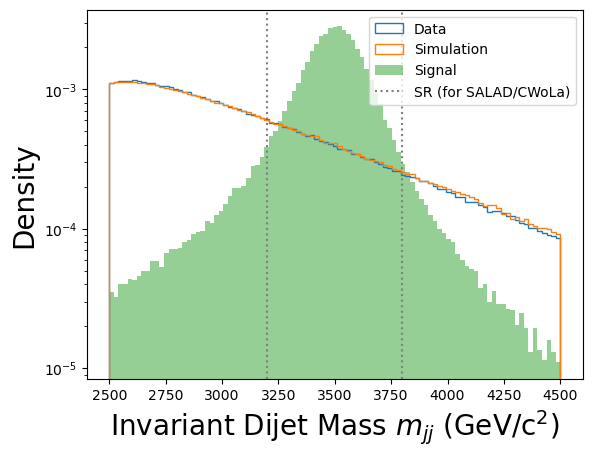

In [2]:
bins = np.linspace(all_data.mjj.min(), all_data.mjj.max(), 100)
plt.hist(data.mjj, bins=bins, label='Data', histtype='step', density=1)
plt.hist(sim.mjj, bins=bins, label='Simulation', histtype='step', density=1)
plt.hist(signal.mjj, bins=bins, label='Signal', alpha=0.5, density=1)

plt.yscale('log')
plt.xlabel('Invariant Dijet Mass $m_{jj}$ (GeV/c$^2$)', fontsize=20)
plt.ylabel('Density', fontsize=20)

plt.axvline(sr[0], color='tab:grey', ls=':')
plt.axvline(sr[1], color='tab:grey', ls=':', label='SR (for SALAD/CWoLa)')

plt.legend()
plt.show()

First, we'll fix our signal significance (in the signal region training dataset) at 2$\sigma$. We can pick a test fraction of 0.5, and a training fraction of 0.8.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
test_frac = 0.5
train_frac = 0.8


data_train, data_test = train_test_split(data, test_size=test_frac)
sim_train, sim_test = train_test_split(sim, test_size=test_frac)

sig = 2.0 # sigma
n_sig = int(np.round(sig*np.sqrt(len(data_train)),0))
signal_test, signal_train = train_test_split(signal, test_size=n_sig/len(signal))

# add data to signal to make "data"
data_train, data_test = pd.concat([data_train, signal_train]), pd.concat([data_test, signal_test])

Now we can plot this, and see exactly what is in our training dataset. The test set should look approximately the same.

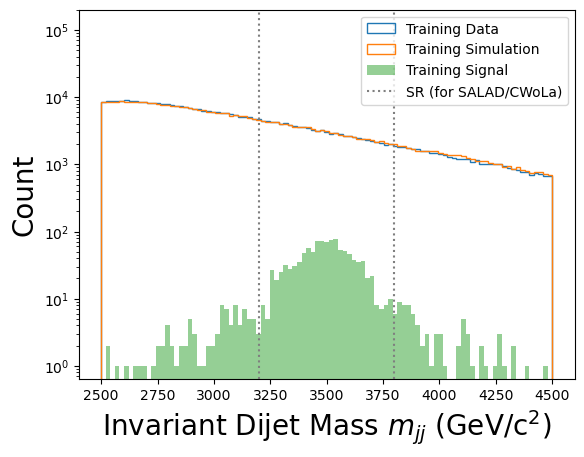

In [4]:
bins = np.linspace(all_data.mjj.min(), all_data.mjj.max(), 100)
plt.hist(data_train[~data_train.signal.astype(bool)].mjj, bins=bins, label='Training Data', histtype='step', density=0)
plt.hist(sim_train.mjj, bins=bins, label='Training Simulation', histtype='step', density=0)
plt.hist(data_train[data_train.signal.astype(bool)].mjj, bins=bins, label='Training Signal', alpha=0.5, density=0)

plt.yscale('log')
plt.xlabel('Invariant Dijet Mass $m_{jj}$ (GeV/c$^2$)', fontsize=20)
plt.ylabel('Count', fontsize=20)

plt.axvline(sr[0], color='tab:grey', ls=':')
plt.axvline(sr[1], color='tab:grey', ls=':', label='SR (for SALAD/CWoLa)')

plt.legend(loc='upper right')
plt.ylim(plt.ylim()[0], 2e5)
plt.show()

Great! Now we can move to start training various models and evaluating their performances.

### t-SNE

This is the easiest model to run, though the operating mechanics are confusing to understand.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.066454
[t-SNE] Computed conditional probabilities in 0.061s
[t-SNE] Iteration 50: error = 84.4567184, gradient norm = 0.0115218 (50 iterations in 0.599s)
[t-SNE] Iteration 100: error = 83.0557556, gradient norm = 0.0000094 (50 iterations in 0.509s)
[t-SNE] Iteration 150: error = 83.0557556, gradient norm = 0.0000119 (50 iterations in 0.501s)
[t-SNE] Iteration 200: error = 83.0557098, gradient norm = 0.0000117 (50 iterations in 0.509s)
[t-SNE] Iteration 250: error = 83.0557404, gradient norm = 0.0000118

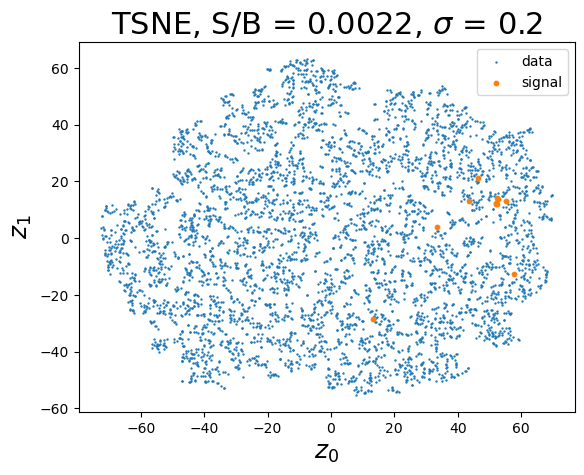

In [5]:
from sklearn.manifold import TSNE

n_fit = 5000
n_components = 2
n_iter = 1000

features = [
#     'pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
#     'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 
    'mjj', 'pTj1', 'pTj2', 'maxmass', 'minmass', 'tau21a', 'tau21b'
]

tsne_train = data_train.sample(n_fit)
norm_factors = data_train[features].max(axis=0).values

tsne = TSNE(n_components=n_components, n_iter=n_iter, verbose=2)
tsne_xhat = tsne.fit_transform((tsne_train[features]/norm_factors))

plt.scatter(*tsne_xhat[tsne_train.signal==0].T, s=0.5, label='data')
plt.scatter(*tsne_xhat[tsne_train.signal==1].T, s=10, label='signal')
plt.xlabel('$z_0$', fontsize=18)
plt.ylabel('$z_1$', fontsize=18)
plt.title('TSNE, S/B = {:.4f}, $\sigma$ = {:.1f}'.format(
    np.divide(*tsne_train.signal.value_counts().values[::-1]),
    tsne_train.signal.sum()/np.sqrt((tsne_train.signal==0).sum())
), fontsize=22)
plt.legend()
plt.show()

As you will likely see, the separation doesn't work very well. This is because there simply is not enough signal events (or they are not different enough from the qcd events) for them to show up distinctly in the scatter plot made by TSNE:

However, if we train on a much higher signal density, it will recognize (the test dataset has high signal density, something like 1:1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.066868
[t-SNE] Computed conditional probabilities in 0.059s
[t-SNE] Iteration 50: error = 84.0344391, gradient norm = 0.0127328 (50 iterations in 0.694s)
[t-SNE] Iteration 100: error = 82.4811096, gradient norm = 0.0000339 (50 iterations in 0.536s)
[t-SNE] Iteration 150: error = 82.4810181, gradient norm = 0.0000247 (50 iterations in 0.543s)
[t-SNE] Iteration 200: error = 82.4810181, gradient norm = 0.0000228 (50 iterations in 0.549s)
[t-SNE] Iteration 250: error = 82.4810333, gradient norm = 0.0000238

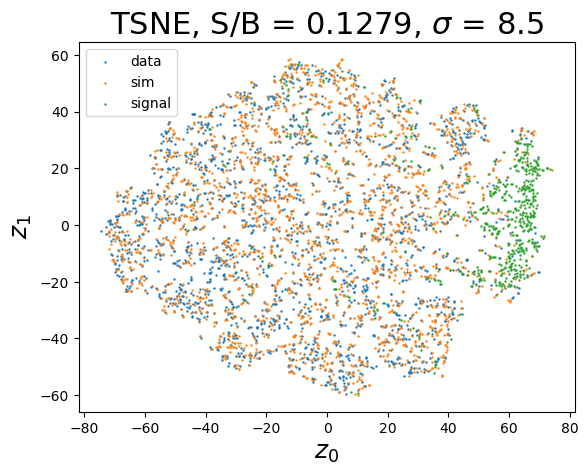

In [6]:
from sklearn.manifold import TSNE

n_fit = 5000
n_components = 2
n_iter = 1000

features = [
#     'pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
#     'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 
    'mjj', 'pTj1', 'pTj2', 'maxmass', 'minmass', 'tau21a', 'tau21b'
]

tsne_train = pd.concat([data_test, sim_test]).sample(n_fit)
norm_factors = data_test[features].max(axis=0).values

tsne = TSNE(n_components=n_components, n_iter=n_iter, verbose=2)
tsne_xhat = tsne.fit_transform((tsne_train[features]/norm_factors))

plt.scatter(*tsne_xhat[(tsne_train.signal==0) & (tsne_train.herwig == 0)].T, s=0.5, label='data')
plt.scatter(*tsne_xhat[(tsne_train.signal==0) & (tsne_train.herwig == 1)].T, s=0.5, label='sim')
plt.scatter(*tsne_xhat[(tsne_train.signal==1) & (tsne_train.herwig == 0)].T, s=0.5, label='signal')
plt.legend()
plt.xlabel('$z_0$', fontsize=18)
plt.ylabel('$z_1$', fontsize=18)
plt.title('TSNE, S/B = {:.4f}, $\sigma$ = {:.1f}'.format(
    np.divide(*tsne_train.signal.value_counts().values[::-1]),
    tsne_train.signal.sum()/np.sqrt((tsne_train.signal==0).sum())
), fontsize=22)
plt.show()

If we thought this representation was particularly good, we could train a neural network to discriminate between the two.

#### Challenge:

Train a neural network to learn the mapping from input dataset to TSNE output, so that it can be applied to arbitrary data (TSNE is a transform and cannot be applied to any dataset, it must also learn from it).

# Autoencoder

Autoencoders were one of the first applications of ML to physics anomaly detection. 
[This paper](https://arxiv.org/abs/1811.10276) from 2018 is an implementation of variational autoencoders (we will build up to this principle).

The basic principle of an autoencoder is to learn a latent representation of a dataset, and then identifying outliers in this dataset as "signal." This is done by training a network to reproduce the input data exactly, under some constraint. 

This constraint comes in various formats, but for a neural autoencoder (which we are starting with) it is done simply by creating a bottleneck of nodes in the architecture, as shown here: 


![](https://github.com/luclepot/HEPxML_2023_unsupervised_learning/blob/main/images/autoencoder.png?raw=1)

We continue our code by doing this here:

In [7]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims, middle, input_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, middle)
        self.linear2 = nn.Linear(middle, middle)
        self.linear3 = nn.Linear(middle, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        z = self.linear3(x)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims, middle, input_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, middle)
        self.linear2 = nn.Linear(middle, middle)
        self.linear3 = nn.Linear(middle, input_dim)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = F.tanh(self.linear3(z))
        return z

class Autoencoder(nn.Module):
    def __init__(self, n_features, neck, middle):
        super().__init__()
        self.encoder = Encoder(neck, middle, n_features)
        self.decoder = Decoder(neck, middle, n_features)
        
    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x,latent

In [8]:
import tqdm

features = [
#     'pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
#     'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 
    'mjj', 'pTj1', 'pTj2', 'maxmass', 'minmass', 'tau21a', 'tau21b'
]
neck = 2
middle = 4

batch_size=500
learning_rate = 1e-3
epochs = 10

ae = Autoencoder(len(features), neck, middle)
crit = nn.MSELoss()
opt = torch.optim.AdamW(ae.parameters(), lr=learning_rate)

Epoch   9, last loss   0.006: 100%|███████████████████| 611/611 [00:00<00:00, 1095.78it/s]


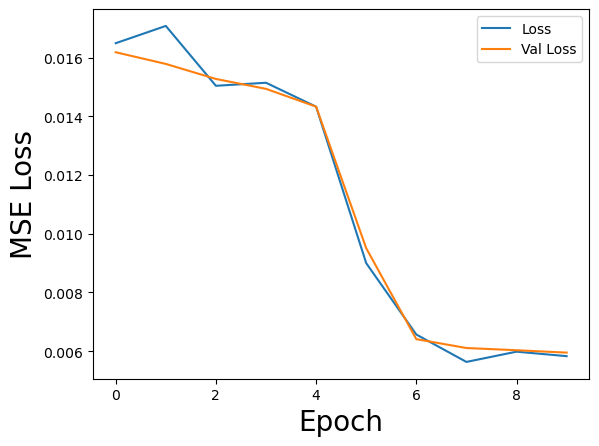

In [9]:
norm_factors = data_train[features].max(axis=0)

train_dataset, val_dataset = random_split(
    torch.Tensor((data_train[features]/norm_factors).values),
    [train_frac, 1-train_frac]
)

train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

losses = []
val_losses = []
for epoch in range(epochs):
    iterator = tqdm.tqdm(train_dl, total=len(train_dl), desc='Epoch {:>3}, last loss {:>7.3f}'.format(epoch, -1 if epoch == 0 else losses[epoch-1]))
    for x in iterator:
        xhat, z = ae(x)
        loss = crit(xhat, x)
        loss.backward()
        opt.step()
        opt.zero_grad()
    ae.eval()
    xhattest,_ = ae(val_dataset.dataset)
    val_loss = crit(xhattest, val_dataset.dataset)
    
    val_losses.append(val_loss.data.item())
    losses.append(loss.data.item())
    
plt.plot(losses, label='Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.legend()
plt.show()

It is interesting to get the MSE, and then to plot both that and the latent space. This gives some intuition as to what is happening.

In [10]:
xhat, z = ae(torch.Tensor((data_test[features]/norm_factors).values))
_, ztrain = ae(torch.Tensor((data_train[features]/norm_factors).values))

mse = (data_test[features]/norm_factors - xhat.detach().numpy())**2.
z = z.detach().numpy()
ztrain = ztrain.detach().numpy()

MSE plots:

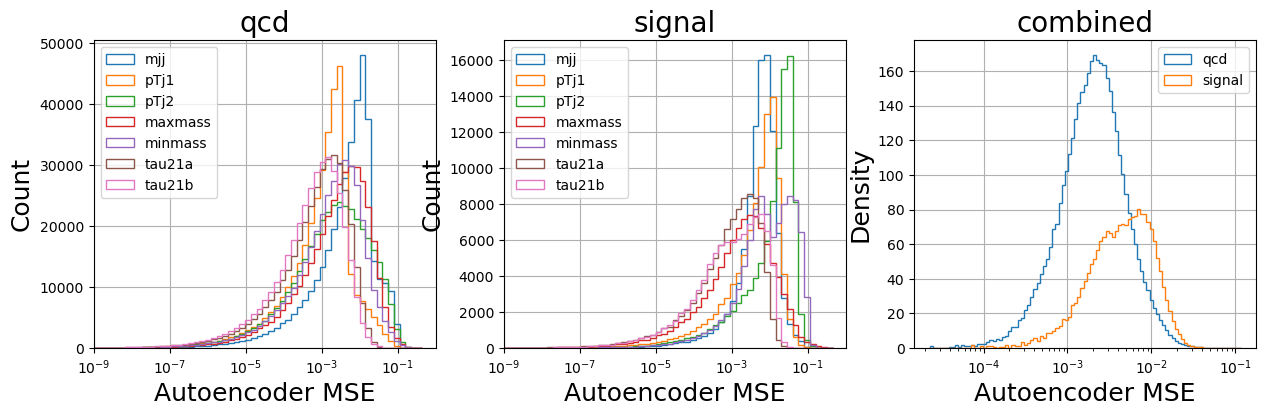

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
bins = np.logspace(np.log10(mse.values.min()), np.log10(mse.values.max()), 100)

for i,name in enumerate(['qcd', 'signal', 'combined']):
    ax = axs[i]
    if i == 2:
        bins = np.logspace(np.log10(mse.mean(axis=1).values.min()), np.log10(mse.mean(axis=1).values.max()), 100)
        ax.hist(mse[data_test.signal == 0].mean(axis=1), label='qcd', histtype='step', bins=bins, density=1)
        ax.hist(mse[data_test.signal == 1].mean(axis=1), label='signal', histtype='step', bins=bins, density=1)
        

    else:
        bins = np.logspace(np.log10(mse.values.min()), np.log10(mse.values.max()), 100)
        for c in mse:
            ax.hist(
                mse[data_test.signal == i][c], bins=bins, 
                label=c, histtype='step'
            )
    ax.legend()
    ax.set_xscale('log')
    if i == 2:
        ax.set_ylabel('Density', fontsize=18)
    else:
        ax.set_ylabel('Count', fontsize=18)
        ax.set_xlim(1e-9, 1e0)
    ax.grid()
    ax.set_xlabel('Autoencoder MSE', fontsize=18)
    ax.set_title(name, fontsize=20)

plt.show()

Latent space:

/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/2636055757.py:16: RuntimeWarning: divide by zero encountered in divide
  h = ax.pcolor(np.nan_to_num(vals[1].T/vals[0].T, 1, posinf=1))
/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/2636055757.py:16: RuntimeWarning: invalid value encountered in divide
  h = ax.pcolor(np.nan_to_num(vals[1].T/vals[0].T, 1, posinf=1))


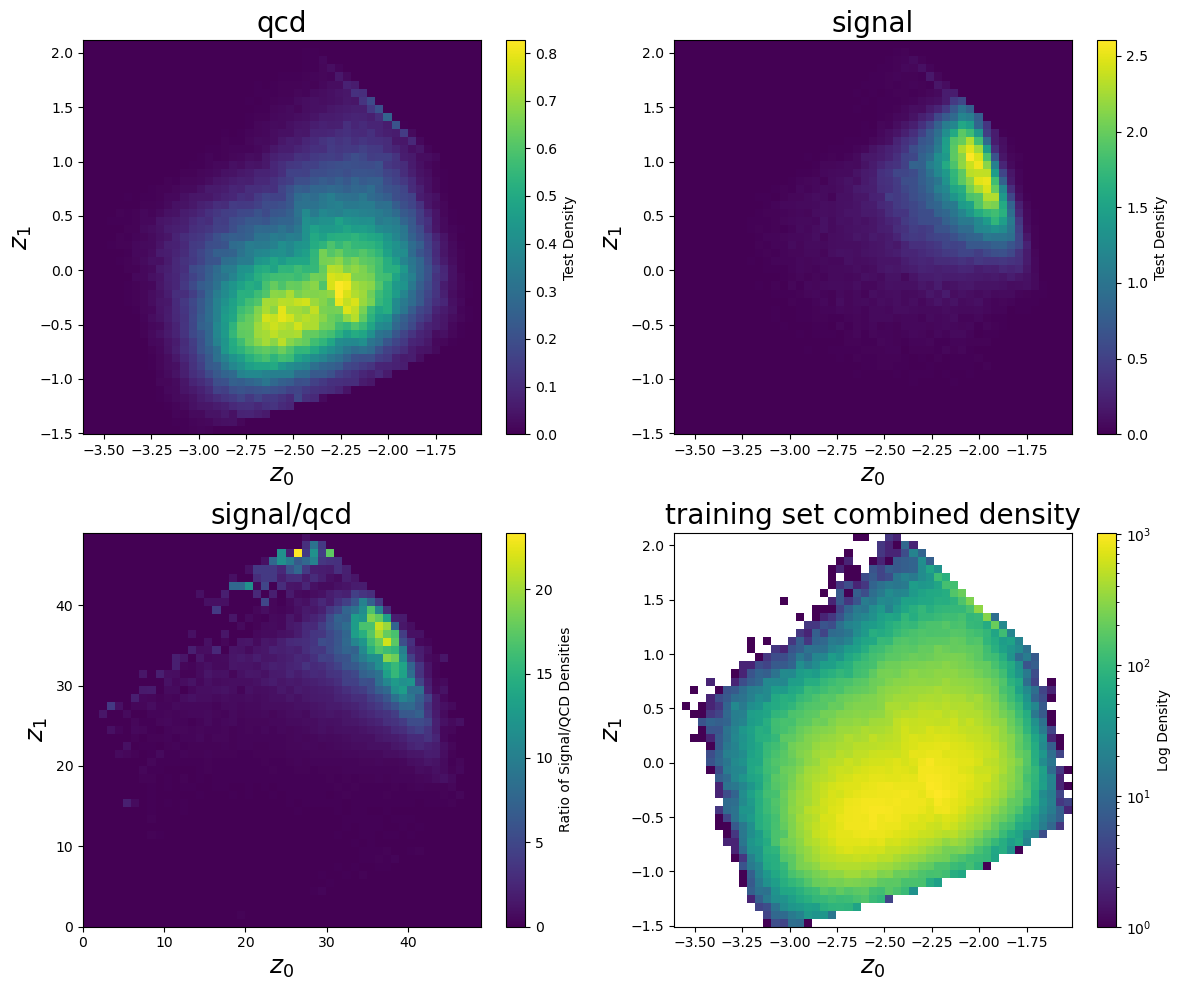

In [12]:
import matplotlib as mpl

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
bx, by = [np.linspace(*arg, 50) for arg in zip(z.min(axis=0), z.max(axis=0))]
vals = []
for i,name in enumerate(['qcd', 'signal']):
    ax = axs[i]
    h = ax.hist2d(z[data_test.signal == i,0], z[data_test.signal == i,1], bins=(bx, by), density=1)
    vals.append(h[0])
    fig.colorbar(h[3], ax=ax, label='Test Density')
    ax.set_xlabel('$z_0$', fontsize=18)
    ax.set_ylabel('$z_1$', fontsize=18)
    ax.set_title(name, fontsize=20)
ax = axs[2]
h = ax.pcolor(np.nan_to_num(vals[1].T/vals[0].T, 1, posinf=1))
fig.colorbar(h, ax=ax, label='Ratio of Signal/QCD Densities',)
ax.set_xlabel('$z_0$', fontsize=18)
ax.set_ylabel('$z_1$', fontsize=18)
ax.set_title('signal/qcd', fontsize=20)

ax = axs[3]
h = ax.hist2d(*ztrain.T, bins=(bx, by), norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='Log Density', )
ax.set_xlabel('$z_0$', fontsize=18)
ax.set_ylabel('$z_1$', fontsize=18)
ax.set_title('training set combined density', fontsize=20)

plt.tight_layout()
plt.show()

Lastly, we need to get the ROC/AUC scores and significance improvement. Sklearn can help us:

/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/1016778016.py:19: RuntimeWarning: invalid value encountered in divide
  ax.plot(tpr, tpr/np.sqrt(fpr))


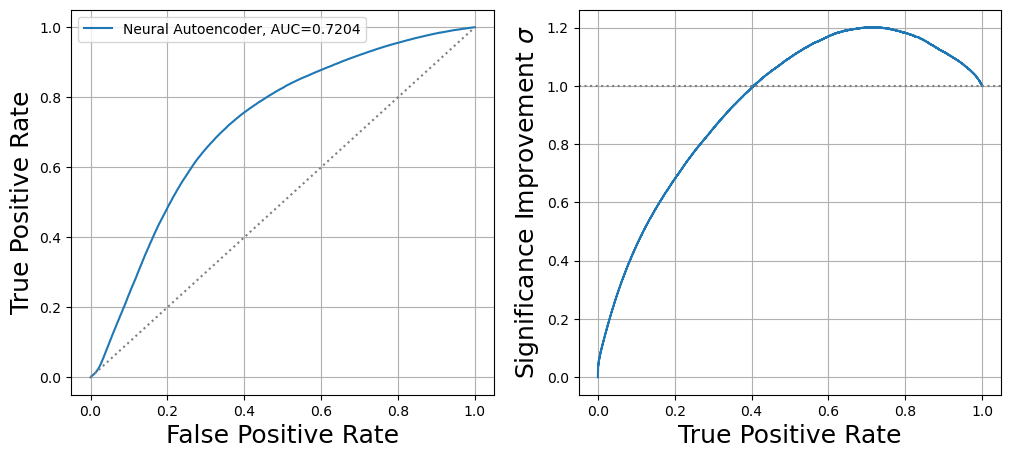

In [13]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

name = 'Neural Autoencoder'

fig, axs = plt.subplots(1, 2, figsize=(12,5))

# try with other yhats! z[:,0], np.mean(z, axis=1), etc. some might work better.
yhat = mse.mean(axis=1)
fpr, tpr, thresh = roc_curve(data_test.signal, yhat)
this_auc = auc(fpr, tpr)
ax = axs[0]
ax.plot(fpr, tpr, label='{}, AUC={:.4f}'.format(name, this_auc))
ax.plot(fpr, fpr, ls=':', color='tab:grey')
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.legend()
ax.grid()
ax = axs[1]
ax.plot(tpr, tpr/np.sqrt(fpr))
ax.set_xlabel('True Positive Rate', fontsize=18)
ax.set_ylabel('Significance Improvement $\sigma$', fontsize=18)
ax.axhline(1.0, ls=':', color='tab:grey')
ax.grid()
ROCS[name] = tpr, fpr, this_auc
plt.show()

# Variational autoencoder


This time we are doing basically the same thing as we did with the Autoencoder, but adding the variational bottleneck as described in lecture. This forces the latent space dimensions to be 

In [14]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, middle, input_dim):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, middle)
        self.linear2 = nn.Linear(middle, middle)
        self.linear3 = nn.Linear(middle, latent_dims)
        self.linear4 = nn.Linear(middle, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
#         self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
#         self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu =  self.linear3(x)
        sigma = torch.exp(self.linear4(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims, middle, input_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, middle)
        self.linear2 = nn.Linear(middle, middle)
        self.linear3 = nn.Linear(middle, input_dim)
        

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = F.sigmoid(self.linear3(z))
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self,  n_features, neck, middle):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(neck, middle, n_features)
        self.decoder = Decoder(neck, middle, n_features)

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x,z

Epoch  39, last loss 362.193: 100%|████████████████████| 611/611 [00:00<00:00, 937.09it/s]


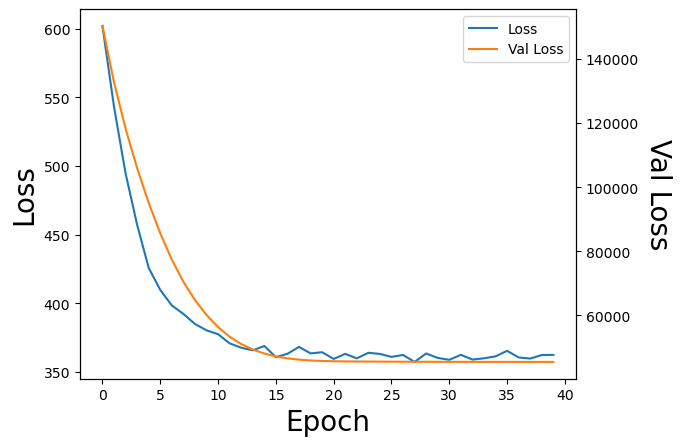

In [15]:
import tqdm

features = [
#     'pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
#     'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 
    'mjj', 'pTj1', 'pTj2', 'maxmass', 'minmass', 'tau21a', 'tau21b'
]
neck = 2
middle = 4
learning_rate = 5e-5
epochs = 40

vae = VariationalAutoencoder(len(features), neck, middle)
opt = torch.optim.AdamW(vae.parameters(), lr=learning_rate)

norm_factors = data_train[features].max(axis=0)

train_dataset, val_dataset = random_split(
    torch.Tensor((data_train[features]/norm_factors).values),
    [train_frac, 1-train_frac]
)

train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

losses = []
val_losses = []

for epoch in range(epochs):
    iterator = tqdm.tqdm(train_dl, total=len(train_dl), desc='Epoch {:>3}, last loss {:>7.3f}'.format(epoch, -1 if epoch == 0 else losses[epoch-1]))
    for x in iterator:
        xhat, z = vae(x)
        loss = ((x - xhat)**2.).sum() + vae.encoder.kl
        loss.backward()
        opt.step()
        opt.zero_grad()
    vae.eval()
    xhattest,_ = vae(val_dataset.dataset)
    val_loss = ((val_dataset.dataset - xhattest)**2.).sum()
    
    val_losses.append(val_loss.data.item())
    losses.append(loss.data.item())

ax = plt.gca()
ax1 = ax.twinx()
h1 = ax.plot(losses, label='Loss')
h2 = ax1.plot(val_losses, label='Val Loss', color='tab:orange')
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax1.set_ylabel('Val Loss', fontsize=20, rotation=270, va='bottom')

plt.legend(labels=['Loss', 'Val Loss'], handles = h1 +h2)
plt.show()

In [16]:
xhat, z = vae(torch.Tensor((data_test[features]/norm_factors).values))
_, ztrain = vae(torch.Tensor((data_train[features]/norm_factors).values))

mse = (data_test[features]/norm_factors - xhat.detach().numpy())**2.
z = z.detach().numpy()
ztrain = ztrain.detach().numpy()

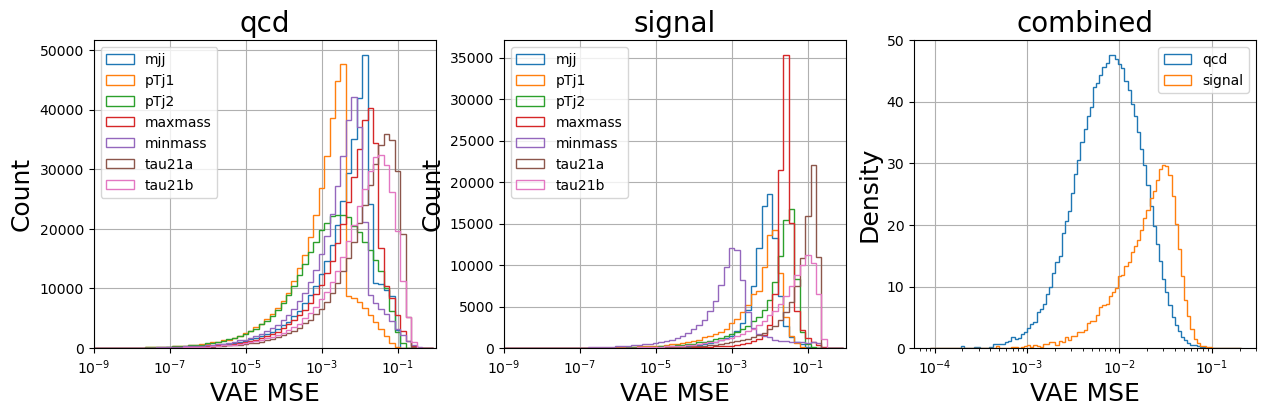

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
bins = np.logspace(np.log10(mse.values.min()), np.log10(mse.values.max()), 100)

for i,name in enumerate(['qcd', 'signal', 'combined']):
    ax = axs[i]
    if i == 2:
        bins = np.logspace(np.log10(mse.mean(axis=1).values.min()), np.log10(mse.mean(axis=1).values.max()), 100)
        ax.hist(mse[data_test.signal == 0].mean(axis=1), label='qcd', histtype='step', bins=bins, density=1)
        ax.hist(mse[data_test.signal == 1].mean(axis=1), label='signal', histtype='step', bins=bins, density=1)
        

    else:
        bins = np.logspace(np.log10(mse.values.min()), np.log10(mse.values.max()), 100)
        for c in mse:
            ax.hist(
                mse[data_test.signal == i][c], bins=bins, 
                label=c, histtype='step'
            )
    ax.legend()
    ax.set_xscale('log')
    if i == 2:
        ax.set_ylabel('Density', fontsize=18)
    else:
        ax.set_ylabel('Count', fontsize=18)
        ax.set_xlim(1e-9, 1e0)
    ax.grid()
    ax.set_xlabel('VAE MSE', fontsize=18)
    ax.set_title(name, fontsize=20)

plt.show()

/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/556652628.py:16: RuntimeWarning: divide by zero encountered in divide
  h = ax.pcolor(np.nan_to_num(vals[1].T/vals[0].T, 1, posinf=1), vmin=0, vmax=4)
/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/556652628.py:16: RuntimeWarning: invalid value encountered in divide
  h = ax.pcolor(np.nan_to_num(vals[1].T/vals[0].T, 1, posinf=1), vmin=0, vmax=4)


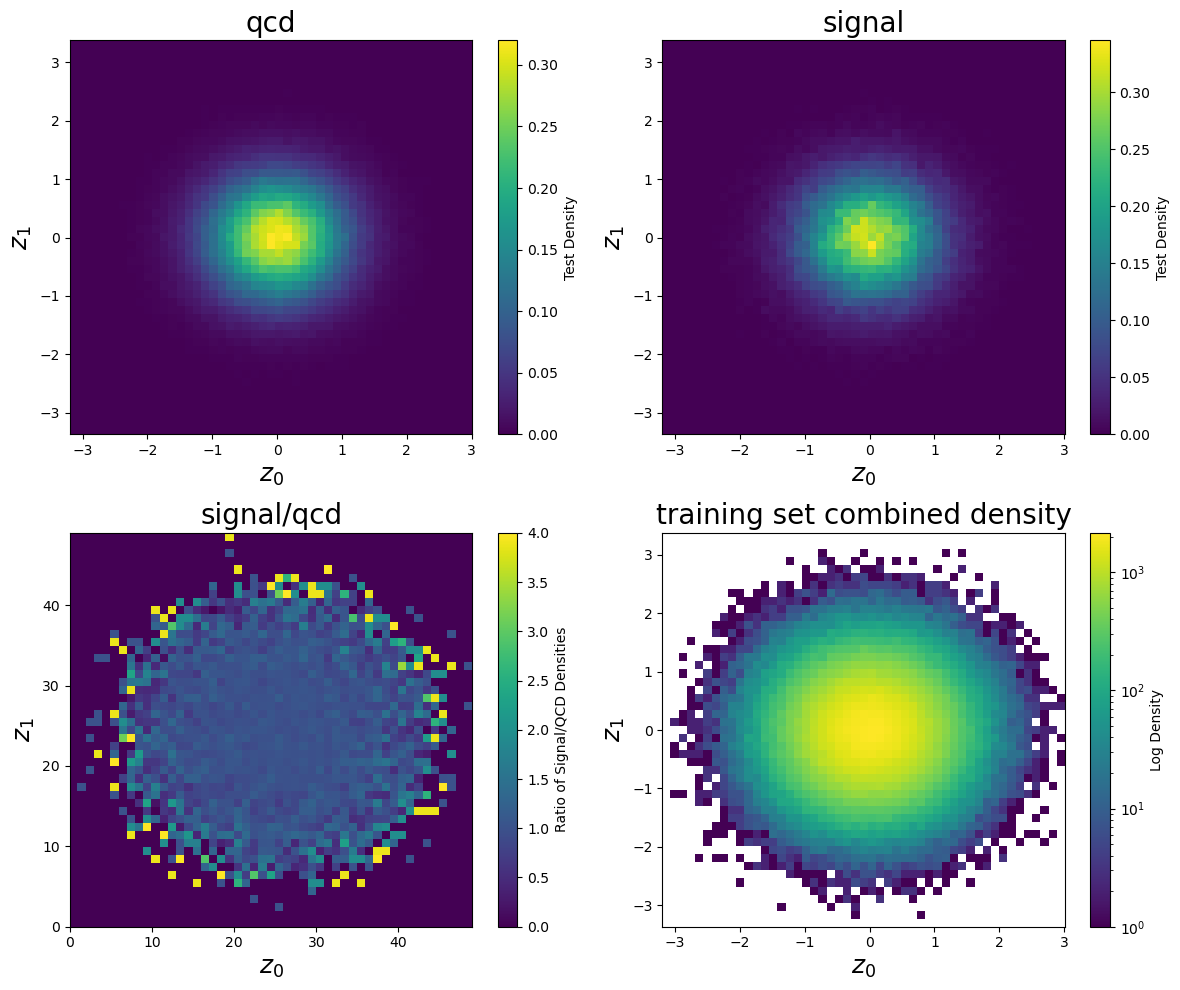

In [18]:
import matplotlib as mpl

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
bx, by = [np.linspace(*arg, 50) for arg in zip(z.min(axis=0), z.max(axis=0))]
vals = []
for i,name in enumerate(['qcd', 'signal']):
    ax = axs[i]
    h = ax.hist2d(z[data_test.signal == i,0], z[data_test.signal == i,1], bins=(bx, by), density=1, )
    vals.append(h[0])
    fig.colorbar(h[3], ax=ax, label='Test Density')
    ax.set_xlabel('$z_0$', fontsize=18)
    ax.set_ylabel('$z_1$', fontsize=18)
    ax.set_title(name, fontsize=20)
ax = axs[2]
h = ax.pcolor(np.nan_to_num(vals[1].T/vals[0].T, 1, posinf=1), vmin=0, vmax=4)
fig.colorbar(h, ax=ax, label='Ratio of Signal/QCD Densities',)
ax.set_xlabel('$z_0$', fontsize=18)
ax.set_ylabel('$z_1$', fontsize=18)
ax.set_title('signal/qcd', fontsize=20)

ax = axs[3]
h = ax.hist2d(*ztrain.T, bins=(bx, by), norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='Log Density', )
ax.set_xlabel('$z_0$', fontsize=18)
ax.set_ylabel('$z_1$', fontsize=18)
ax.set_title('training set combined density', fontsize=20)

plt.tight_layout()
plt.show()

/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/2528449435.py:20: RuntimeWarning: invalid value encountered in divide
  ax.plot(tpr, tpr/np.sqrt(fpr))


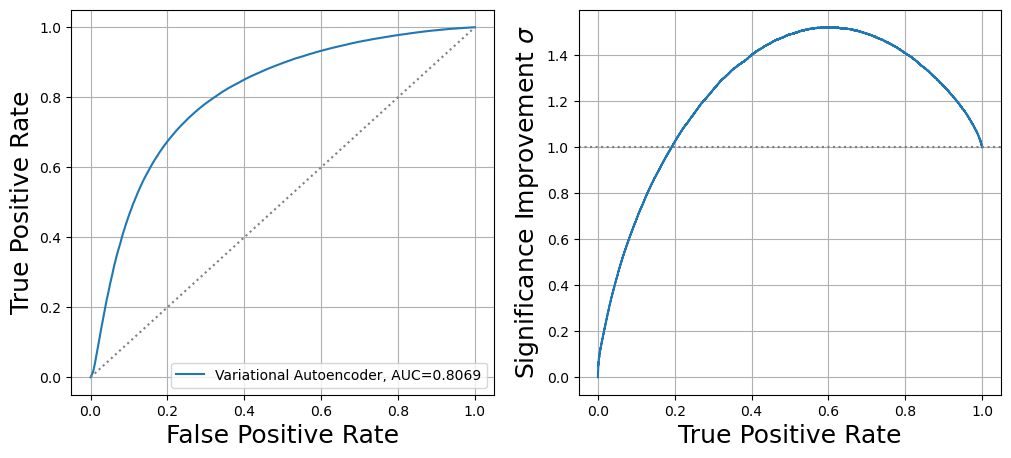

In [19]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

name = 'Variational Autoencoder'

fig, axs = plt.subplots(1, 2, figsize=(12,5))

# try with other yhats! z[:,0], np.mean(z, axis=1), etc. some might work better.
yhat = mse.mean(axis=1)
fpr, tpr, thresh = roc_curve(data_test.signal, yhat)
this_auc = auc(fpr, tpr)

ax = axs[0]
ax.plot(fpr, tpr, label='{}, AUC={:.4f}'.format(name, this_auc))
ax.plot(fpr, fpr, ls=':', color='tab:grey')
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.legend()
ax.grid()
ax = axs[1]
ax.plot(tpr, tpr/np.sqrt(fpr))
ax.set_xlabel('True Positive Rate', fontsize=18)
ax.set_ylabel('Significance Improvement $\sigma$', fontsize=18)
ax.axhline(1.0, ls=':', color='tab:grey')
ax.grid()
ROCS[name] = tpr, fpr, this_auc
plt.show()

We should find that the VAE does slightly better than the AE. Similar improvements to the VAE are pretty easy to make.

# Classification without Labels

I'll guide us through the implementation of CWoLa here!

First, write code to set up a standard neural network in torch, from the skeleton code:

In [20]:
class Network(nn.Module):
    def __init__(self, input_dim):
        super(Network, self).__init__()
        # define fully connected layers here
        self.linear1 = nn.Linear(input_dim, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 1)

    def forward(self, x):
        # define forward here
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        y = F.sigmoid(self.linear3(x))
        return y

Next, write code to create a dataloader for the dataset, using the `data_train` data and separating by the `sr` variable, using the feature `mjj`

You should also pick a subset of the features to train with; probably it is easiest to use only a few features at first. 
`maxmass`, `minmass`, `tau21a`, and `tau21b` are a good start.

Hint: Using the `between` function of pandas will be a good start.

In [28]:
# create y-labels for data

y_train = data_train.mjj.between(*sr).astype(int)

# define features

features = [
    'maxmass', 'minmass', 'tau21a', 'tau21b'
]

# make a combined x and y dataset using TensorDataset, with normalization factors included

norm_factors = data_train[features].max(axis=0)
combined_train = TensorDataset(
    torch.Tensor((data_train[features]/norm_factors).values),
    torch.Tensor(y_train.values[:,np.newaxis])
)

# make training/validation split with random_split

train_dataset, val_dataset = random_split(combined_train, [train_frac, 1-train_frac])

# make training loader using DataLoader, 
# and extract tensors for x_validation and y_validation.

batch_size = 500
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_x, val_y = val_dataset.dataset.tensors

Next, define an instance of the model and train, with the necessary parameters.



Epoch   9, last loss   0.531: 100%|████████████████████| 611/611 [00:00<00:00, 732.20it/s]


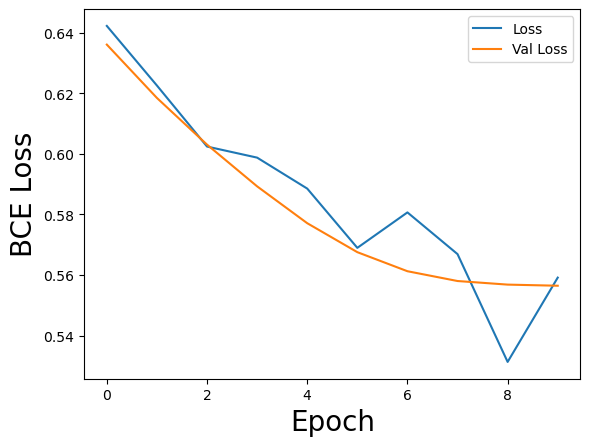

In [29]:
# define features
learning_rate = 2e-5
epochs = 10

cwola = Network(len(features))
opt = torch.optim.AdamW(cwola.parameters(), lr=learning_rate)
loss = nn.BCELoss()

# track validation loss etc
losses = []
val_losses = []

# make for-loop over epochs
for epoch in range(epochs):
    iterator = tqdm.tqdm(train_dl, total=len(train_dl), desc='Epoch {:>3}, last loss {:>7.3f}'.format(epoch, -1 if epoch == 0 else losses[epoch-1]))
    for x,y in iterator:
        yhat = cwola(x)
        output = loss(yhat, y)
        output.backward()

        opt.step()
        opt.zero_grad()
        
    cwola.eval()
    val_yhat = cwola(val_x)
    val_loss = loss(val_yhat, val_y)
    
    val_losses.append(val_loss.item())
    losses.append(output.item())

# plot loss/val loss
plt.plot(losses, label='Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('BCE Loss', fontsize=20)
plt.legend()
plt.show()

Lastly, we need to implement an analysis of the results. This will be easy enough using the test dataset that we have set for ourselves. Make sure to use the `roc_curve` and `auc` functions from previous examples (in fact, you can almost totally copy the code!)

/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/1216162474.py:24: RuntimeWarning: invalid value encountered in divide
  ax.plot(tpr, tpr/np.sqrt(fpr))


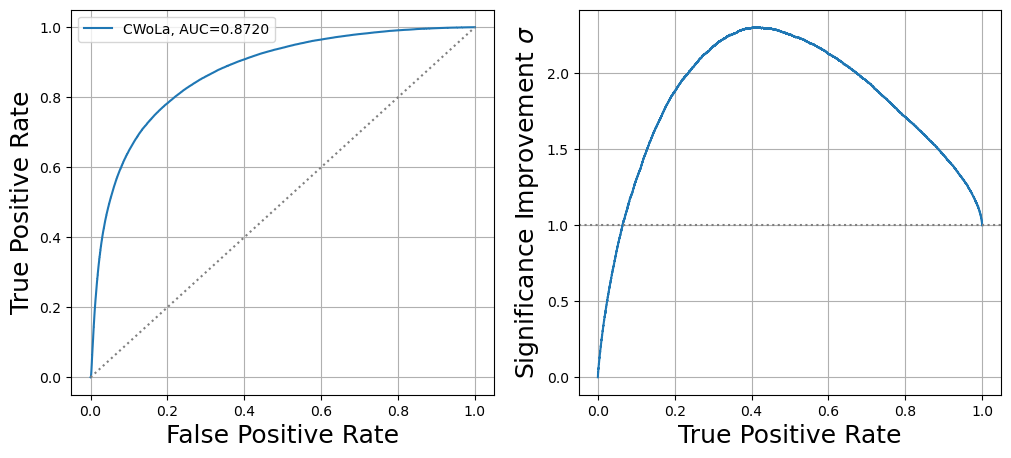

In [30]:
# use cwola model to get yhat scores for the test dataset.
# take care to use appropriate normalization factors!

yhat_test = cwola(torch.Tensor((data_test[features]/norm_factors).values)).detach().numpy()

# use sklearn functions to calculate the true positive rate, 
# false positive rate, and AUC

name = 'CWoLa'
fpr, tpr, thresh = roc_curve(data_test.signal, yhat_test)
this_auc = auc(fpr, tpr)

# plot results

fig, axs = plt.subplots(1, 2, figsize=(12,5))
ax = axs[0]
ax.plot(fpr, tpr, label='{}, AUC={:.4f}'.format(name, this_auc))
ax.plot(fpr, fpr, ls=':', color='tab:grey')
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.legend()
ax.grid()
ax = axs[1]
ax.plot(tpr, tpr/np.sqrt(fpr))
ax.set_xlabel('True Positive Rate', fontsize=18)
ax.set_ylabel('Significance Improvement $\sigma$', fontsize=18)
ax.axhline(1.0, ls=':', color='tab:grey')
ax.grid()
ROCS[name] = tpr, fpr, this_auc
plt.show()

Lastly, we compare all of the results! This can be done fairly easily with the dictionary we have made.

If you re-run all of your models, you'll see that the performances vary significantly based on trainings. For the autoencoders, this is because the training is quite random, so whether or not signal is picked up by a metric like MSE is more randomized. 

/var/folders/jp/5mp545d16tn0grhnx6bw_xtw0000gn/T/ipykernel_57980/3927961251.py:14: RuntimeWarning: invalid value encountered in divide
  ax.plot(tpr, tpr/np.sqrt(fpr))


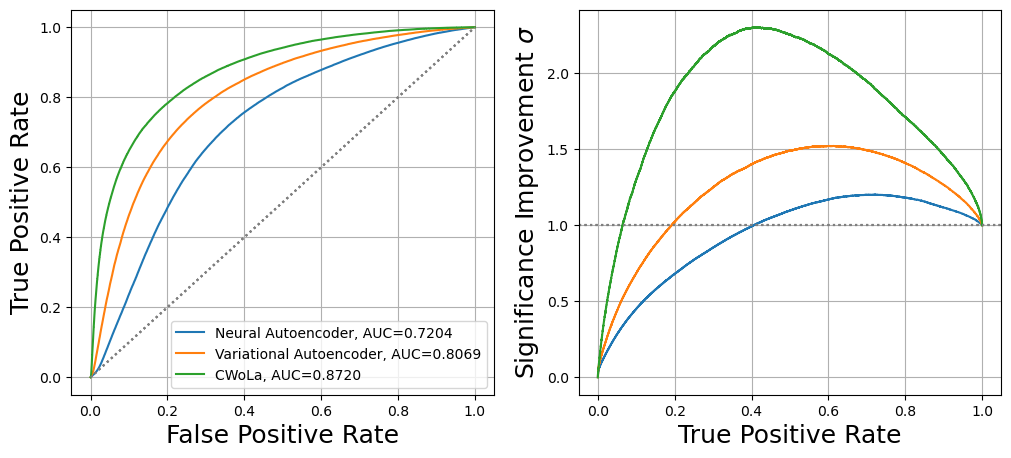

In [31]:
# loop through dictionary and plot results, using your plotting code from above

fig, axs = plt.subplots(1, 2, figsize=(12,5))
for name,(tpr, fpr, this_auc) in ROCS.items():

    ax = axs[0]
    ax.plot(fpr, tpr, label='{}, AUC={:.4f}'.format(name, this_auc))
    ax.plot(fpr, fpr, ls=':', color='tab:grey')
    ax.set_ylabel('True Positive Rate', fontsize=18)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.legend()
    ax.grid()
    ax = axs[1]
    ax.plot(tpr, tpr/np.sqrt(fpr))
    ax.set_xlabel('True Positive Rate', fontsize=18)
    ax.set_ylabel('Significance Improvement $\sigma$', fontsize=18)
    ax.axhline(1.0, ls=':', color='tab:grey')
    ax.grid()
    
plt.show()